In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.pipeline import FeatureUnion

In [2]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn import utils
import sklearn

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn import utils
import sklearn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb



In [4]:
from collections import Counter, OrderedDict
import collections

In [5]:
import joblib


In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [7]:
import re

In [8]:
from textblob import TextBlob

Based on https://www.kaggle.com/venomsnake/analyzing-sarcasm-comprehensive-eda-detection and https://github.com/surajr/SarcasmDetection

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df_isarcasm=pd.read_csv("/content/drive/MyDrive/ISarcasm/DataSet/train.En.csv")

In [11]:
df_isarcasm=df_isarcasm[['tweet','sarcastic']]

In [12]:
train, validate, test = \
              np.split(df_isarcasm.sample(frac=1, random_state=42), 
                       [int(.6*len(df_isarcasm)), int(.8*len(df_isarcasm))])

In [13]:
train_new=pd.concat([train, validate], ignore_index=True)

In [14]:
test=pd.read_csv('/content/drive/MyDrive/ISarcasm/Test_dataset/taskA.En.input.csv')

In [15]:
test

,text
0,"Size on the the Toulouse team, That pack is mo..."
1,Pinball!
2,So the Scottish Government want people to get ...
3,villainous pro tip : change the device name on...
4,I would date any of these men 🥺
...,...
1395,I’ve just seen this and felt it deserved a Ret...
1396,Omg how an earth is that a pen !!! 🤡
1397,Bringing Kanye and drake to a tl near you
1398,"I love it when women are referred to as ""girl ..."


In [16]:
def count_character_type(text):
    text=str(text)

    specialChar = 0
    for i in range(0, len(text)):
        ch = text[i]
        if ch == "!":
            specialChar+=1
        
    return specialChar
    
def count_question_mark(text):
    text=str(text)
    specialChar = 0
    for i in range(0, len(text)):
        ch = text[i]
        if ch == "?":
            specialChar+=1
        
    return specialChar

The Python NLP library, TextBlob has a method to roughly quantify if a sentence is fact or opinion.¶
The method outputs a number ranging from 0 to 1, an output close to 0 indicates the sentence is highly factual and close to 1 means the sentence is highly subjective. Here, we take the sum for every comment, an overall higher sum then, will be indicative of higher subjectivity

In [17]:
def get_subjectivity(text):
    return TextBlob(str(text)).sentiment.subjectivity

The distribution of the 4 most important parts-of-speech (Noun, Verb, Adjective,Pronoun) in sarcastic and non sarcastic comments might shed some light, so let's plot it as a grouped bar chart

In [18]:
import spacy

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
nlp = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [21]:
def pos_counter(doc):
    verb_count = 0
    adj_count = 0
    pron_count = 0
    noun_count=0
    for tok in doc:
        if tok.pos_ == "VERB":
            verb_count=verb_count+1
        elif tok.pos_ == "ADJ":
            adj_count=adj_count+1
        elif tok.pos_ == "PRON":
            pron_count=pron_count+1
        elif tok.pos_ == "PROPN":
            noun_count=noun_count+1
    return (verb_count,adj_count,pron_count,noun_count)

In [22]:
def get_verb_count(text):
  verb_count = 0
  doc = nlp(str(text))
  for tok in doc:
        if tok.pos_ == "VERB":
            verb_count=verb_count+1
  return verb_count/len(str(text))

def get_noun_count(text):
  noun_count = 0
  doc = nlp(str(text))
  for tok in doc:
        if tok.pos_ == "PROPN":
            noun_count=noun_count+1
  return noun_count/len(str(text))

def get_pron_count(text):
  pron_count = 0
  doc = nlp(str(text))
  for tok in doc:
        if tok.pos_ == "PRON":
            pron_count=pron_count+1
  return pron_count/len(str(text))


def get_adj_count(text):
  adj_count = 0
  doc = nlp(str(text))
  for tok in doc:
        if tok.pos_ == "ADJ":
            adj_count=adj_count+1
  return adj_count/len(str(text))


def named_entity_preprocess(data):
    sentences = nltk.sent_tokenize(data)
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
    chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)
    return chunked_sentences

#identify whether feature is NE or not
def extract_entity_names(t):
    entity_names = []
    if hasattr(t, 'label') and t.label():
        if t.label() == 'NE':
            entity_names.append(' '.join([child[0] for child in t]))
        else:
            for child in t:
                entity_names.extend(extract_entity_names(child))

    return entity_names

#counting of NE via loop and then normalizing it for each tweet
def named_entity_count(tweet):

#     named_entity_list = []
      
#     for tweet in sample:
    tweet=str(tweet)
    chunked_sentences = named_entity_preprocess(tweet)
    entity_names = []
    for tree in chunked_sentences:
        entity_names.extend(extract_entity_names(tree))
    ne_count = len(entity_names)
    word_count = len(tweet.split())
    ne_score = ne_count / word_count
#     named_entity_list.append(ne_score)
    return ne_score

Sarcastic comments tend to have profanity interspersed within, let's get a count of both sarcastic and non sarcastic and see how they compare

In [23]:
!pip install better_profanity 
from better_profanity import profanity

In [24]:
def count_profane_words(text):
    count = 0
    for sent in str(text).split():
        if profanity.contains_profanity(sent) == True:
            count = count+1
    return count

get entity cloud

In [25]:
def entity_wordcloud(text):
    named_entities = []    
    sent = nlp(str(text))
    for ent in sent.ents:
        if ent.label_ == 'PERSON' or 'ORG' or 'GPE':
            named_entities.append(ent.text)
            
    doc = " ".join(named_entities)
    return doc

In [26]:
!git clone https://github.com/larsmans/sentiwordnet.git

fatal: destination path 'sentiwordnet' already exists and is not an empty directory.


In [27]:
import csv

In [28]:
class load_senti_word_net(object):
    """
    constructor to load the file and read the file as CSV
    6 columns - pos, ID, PosScore, NegScore, synsetTerms, gloss
    synsetTerms can have multiple similar words like abducting#1 abducent#1 and will read each one and calculaye the scores
    """
    
    def __init__(self):
        sent_scores = collections.defaultdict(list)
        with io.open("/content/sentiwordnet/SentiWordNet_3.0.0_20130122.txt") as fname:
            file_content = csv.reader(fname, delimiter='\t',quotechar='"')
            
            for line in file_content:                
                if line[0].startswith('#') :
                    continue                    
                pos, ID, PosScore, NegScore, synsetTerms, gloss = line
                for terms in synsetTerms.split(" "):
                    term = terms.split("#")[0]
                    term = term.replace("-","").replace("_","")
                    key = "%s/%s"%(pos,term.split("#")[0])
                    try:
                        sent_scores[key].append((float(PosScore),float(NegScore)))
                    except:
                        sent_scores[key].append((0,0))
                    
        for key, value in sent_scores.items():
            sent_scores[key] = np.mean(value,axis=0)
        
        self.sent_scores = sent_scores    
     
    """
    For a word,
    nltk.pos_tag(["Suraj"])
    [('Suraj', 'NN')]
    """
    
    def score_word(self, word):
        pos = nltk.pos_tag([word])[0][1]
        return self.score(word, pos)
    
    def score(self,word, pos):
        """
        Identify the type of POS, get the score from the senti_scores and return the score
        """
        
        if pos[0:2] == 'NN':
            pos_type = 'n'
        elif pos[0:2] == 'JJ':
            pos_type = 'a'
        elif pos[0:2] =='VB':
            pos_type='v'
        elif pos[0:2] =='RB':
            pos_type = 'r'
        else:
            pos_type =  0
            
        if pos_type != 0 :    
            loc = pos_type+'/'+word
            score = self.sent_scores[loc]
            if len(score)>1:
                return score
            else:
                return np.array([0.0,0.0])
        else:
            return np.array([0.0,0.0])
        
    """
    Repeat the same for a sentence
    nltk.pos_tag(word_tokenize("My name is Suraj"))
    [('My', 'PRP$'), ('name', 'NN'), ('is', 'VBZ'), ('Suraj', 'NNP')]    
    """    
        
    def score_sentencce(self, sentence):
        pos = nltk.pos_tag(sentence)
        # print (pos)
        mean_score = np.array([0.0, 0.0])
        for i in range(len(pos)):
            mean_score += self.score(pos[i][0], pos[i][1])
            
        return mean_score
    
    def pos_vector(self, sentence):
        pos_tag = nltk.pos_tag(sentence)
        vector = np.zeros(4)
        
        for i in range(0, len(pos_tag)):
            pos = pos_tag[i][1]
            if pos[0:2]=='NN':
                vector[0] += 1
            elif pos[0:2] =='JJ':
                vector[1] += 1
            elif pos[0:2] =='VB':
                vector[2] += 1
            elif pos[0:2] == 'RB':
                vector[3] += 1
                
        return vector
            

In [29]:
def gram_features(features,sentence):
    sentence_rep = replace_reg(str(sentence))
    token = nltk.word_tokenize(sentence_rep)
    token = [porter.stem(i.lower()) for i in token]        
    
    bigrams = nltk.bigrams(token)
    bigrams = [tup[0] + ' ' + tup[1] for tup in bigrams]
    grams = token + bigrams
    #print (grams)
    for t in grams:
        features['contains(%s)'%t]=1.0

In [30]:
def pos_features(features,sentence):
    sentence_rep = replace_reg(sentence)
    token = nltk.word_tokenize(sentence_rep)
    token = [ porter.stem(each.lower()) for each in token]
    pos_vector = sentiments.pos_vector(token)
    for j in range(len(pos_vector)):
        features['POS_'+str(j+1)] = pos_vector[j]
    # print ("done")
    

In [31]:
def capitalization(features,sentence):
    count = 0
    for i in range(len(sentence)):
        count += int(sentence[i].isupper())
    features['Capitalization'] = int(count > 3)
    # print (count)

In [32]:
import nltk
import re

#dictionnary to sentiment analysis
emo_repl = {
    #good emotions
    "&lt;3" : " good ",
    ":d" : " good ",
    ":dd" : " good ",
    ":p" : " good ",
    "8)" : " good ",
    ":-)" : " good ",
    ":)" : " good ",
    ";)" : " good ",
    "(-:" : " good ",
    "(:" : " good ",
    
    "yay!" : " good ",
    "yay" : " good ",
    "yaay" : " good ",
    "yaaay" : " good ",
    "yaaaay" : " good ",
    "yaaaaay" : " good ",    
    #bad emotions
    ":/" : " bad ",
    ":&gt;" : " sad ",
    ":')" : " sad ",
    ":-(" : " bad ",
    ":(" : " bad ",
    ":s" : " bad ",
    ":-s" : " bad "
}

#dictionnary for general (i.e. topic modeler)
emo_repl2 = {
    #good emotions
    "&lt;3" : " heart ",
    ":d" : " smile ",
    ":p" : " smile ",
    ":dd" : " smile ",
    "8)" : " smile ",
    ":-)" : " smile ",
    ":)" : " smile ",
    ";)" : " smile ",
    "(-:" : " smile ",
    "(:" : " smile ",
       
    #bad emotions
    ":/" : " worry ",
    ":&gt;" : " angry ",
    ":')" : " sad ",
    ":-(" : " sad ",
    ":(" : " sad ",
    ":s" : " sad ",
    ":-s" : " sad "
}

#general
re_repl = {
    r"\br\b" : "are",
    r"\bu\b" : "you",
    r"\bhaha\b" : "ha",
    r"\bhahaha\b" : "ha",
    r"\bdon't\b" : "do not",
    r"\bdoesn't\b" : "does not",
    r"\bdidn't\b" : "did not",
    r"\bhasn't\b" : "has not",
    r"\bhaven't\b" : "have not",
    r"\bhadn't\b" : "had not",
    r"\bwon't\b" : "will not",
    r"\bwouldn't\b" : "would not",
    r"\bcan't\b" : "can not",
    r"\bcannot\b" : "can not"    
}

emo_repl_order = [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]
emo_repl_order2 = [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl2.keys()]))]

def replace_emo(sentence):
    sentence2 = sentence
    for k in emo_repl_order:
        sentence2 = sentence2.replace(k,emo_repl[k])
    for r, repl in re_repl.items():
        sentence2 = re.sub(r,repl,sentence2)
    return sentence2

def replace_reg(sentence):
    sentence2 = sentence
    for k in emo_repl_order2:
        sentence2 = sentence2.replace(k,emo_repl2[k])
    for r, repl in re_repl.items(): 
        sentence2 = re.sub(r,repl,sentence2)
    return sentence2

In [33]:
from gensim import corpora, models, similarities
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd

class topic(object):
    def __init__(self, nbtopic = 100, alpha=1,model=None,dicttp=None):
        self.nbtopic = nbtopic
        self.alpha = alpha
        self.porter = nltk.PorterStemmer()
        self.stop = stopwords.words('english')+['.','!','?','"','...','\\',"''",'[',']','~',"'m","'s",';',':','..','$']
        if model!=None and dicttp!=None:
            self.lda = models.ldamodel.LdaModel.load(model)
            self.dictionary =  corpora.Dictionary.load(dicttp)
            
    def fit(self,documents):
        
        documents_mod = documents
        tokens = [nltk.word_tokenize(sentence) for sentence in documents_mod]
        tokens = [[self.porter.stem(t.lower()) for t in sentence if t.lower() not in self.stop] for sentence in tokens]        
            
        self.dictionary = corpora.Dictionary(tokens)
        corpus = [self.dictionary.doc2bow(text) for text in tokens]
        self.lda = models.ldamodel.LdaModel(corpus,id2word=self.dictionary, num_topics=self.nbtopic,alpha=self.alpha)
        
        self.lda.save('topics.tp')
        self.dictionary.save('topics_dict.tp')
        
    def get_topic(self,topic_number):
        
        return self.lda.print_topic(topic_number)
    
    def transform(self,sentence):
        
        sentence_mod = sentence
        tokens = nltk.word_tokenize(sentence_mod)
        tokens = [self.porter.stem(t.lower()) for t in tokens if t.lower() not in self.stop] 
        corpus_sentence = self.dictionary.doc2bow(tokens)
        
        return self.lda[corpus_sentence] 

In [34]:
porter = nltk.PorterStemmer()


In [35]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [36]:
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def sentiment_extract(features, sentence):
    sentence_rep = replace_reg(sentence)
    token = nltk.word_tokenize(sentence_rep)    
    token = [porter.stem(i.lower()) for i in token]   
    mean_sentiment = sentiments.score_sentencce(token)
    sent_score = sid.polarity_scores(sentence)
    
    features["Positive Sentiment"] = mean_sentiment[0]
    features["Negative Sentiment"] = mean_sentiment[1]
    features["Neutral Sentiment"] = sent_score['neu']
    features["sentiment"] = mean_sentiment[0] - mean_sentiment[1]
    #print(mean_sentiment[0], mean_sentiment[1])
    
    try:
        text = TextBlob(" ".join([""+i if i not in string.punctuation and not i.startswith("'") else i for i in token]).strip())
        features["Blob Polarity"] = text.sentiment.polarity
        features["Blob Subjectivity"] = text.sentiment.subjectivity
        #print (text.sentiment.polarity,text.sentiment.subjectivity )
    except:
        features["Blob Polarity"] = 0
        features["Blob Subjectivity"] = 0
        # print("do nothing")
        
    
    first_half = str(token[0:len(token)//2] )  
    mean_sentiment_half = sentiments.score_sentencce(first_half)
    sent_score_half = sid.polarity_scores(first_half)
    features["positive Sentiment first half"] = mean_sentiment_half[0]
    features["negative Sentiment first half"] = mean_sentiment_half[1]
    features["Neutral Sentiment first half"] = sent_score_half['neu']
    features["first half sentiment"] = mean_sentiment_half[0]-mean_sentiment_half[1]
    try:
        text = TextBlob(" ".join([""+i if i not in string.punctuation and not i.startswith("'") else i for i in first_half]).strip())
        features["first half Blob Polarity"] = text.sentiment.polarity
        features["first half Blob Subjectivity"] = text.sentiment.subjectivity
        #print (text.sentiment.polarity,text.sentiment.subjectivity )
    except:
        features["first Blob Polarity"] = 0
        features["first Blob Subjectivity"] = 0
        # print("do nothing")
    
    second_half = str(token[len(token)//2:])
    mean_sentiment_sechalf = sentiments.score_sentencce(second_half)
    sent_score_sechalf = sid.polarity_scores(second_half)
    features["positive Sentiment second half"] = mean_sentiment_sechalf[0]
    features["negative Sentiment second half"] = mean_sentiment_sechalf[1]
    features["Neutral Sentiment second half"] = sent_score_sechalf['neu']
    features["second half sentiment"] = mean_sentiment_sechalf[0]-mean_sentiment_sechalf[1]
    try:
        text = TextBlob(" ".join([""+i if i not in string.punctuation and not i.startswith("'") else i for i in second_half]).strip())
        features["second half Blob Polarity"] = text.sentiment.polarity
        features["second half Blob Subjectivity"] = text.sentiment.subjectivity
        #print (text.sentiment.polarity,text.sentiment.subjectivity )
    except:
        features["second Blob Polarity"] = 0
        features["second Blob Subjectivity"] = 0
        # print("do nothing")  
    

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
topic_mod = topic(nbtopic=200,alpha='symmetric')
topic_mod.fit(train_new['tweet'].values)
# topic_mod = topic(model=os.path.join('topics.tp'),dicttp=os.path.join('topics_dict.tp'))
def topic_feature(features,sentence,topic_modeler):    
    topics = topic_modeler.transform(sentence)    
    for j in range(len(topics)):
        features['Topic :'] = topics[j][1]

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [37]:
!pip install emoji

     |████████████████████████████████| 174 kB 3.8 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=61f4cf8b96c2528abed24aa1c59ddac872a07560d2b1d37fde16a0bb77fac9ae
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [39]:
from emoji import UNICODE_EMOJI



In [40]:
"""
Function to extract the below features.
1. Presence of emoji's
2. Count of number of Question marks
3. Count of number of Exclamation marks
4. presence of hashtags other than #sarcasm
5. presence of any @user tweets

"""
from collections import defaultdict

def Emoji_present(text):
    emoji = {
    "&lt;3" : "positive",":D" : "positive",	":d" : "positive", ":dd" : "positive", ":P" : "positive", ":p" : "positive","8)" : "positive",
    "8-)" : "positive",  ":-)" : "positive",    ":)" : "positive",    ";)" : "positive",    "(-:" : "positive",    "(:" : "positive",
    ":')" : "positive",    "xD" : "positive",    "XD" : "positive",  "yay!" : "positive",  "yay" : "positive",  "yaay" : "positive",
    "yaaay" : "positive",  "yaaaay" : "positive", "yaaaaay" : "positive", "Yay!" : "positive", "Yay" : "positive", "Yaay" : "positive",
    "Yaaay" : "positive", "Yaaaay" : "positive", "Yaaaaay" : "positive",  ":/" : "negative", "&gt;" : "negative", ":'(" : "negative",
    ":-(" : "negative", ":(" : "negative", ":s" : "negative",":-s" : "negative","-_-" : "negative", "-.-" : "negative" }
    emoji_count =defaultdict(int) 
    isPresent=False    
        
    for word in str(text):
        if word in emoji:            
            isPresent = True

    
    count = 0
    for emoji in UNICODE_EMOJI:
        count += str(text).count(emoji)
        if count>=1:
          isPresent=True      

    
    return isPresent 



In [41]:
import io

sentiments = load_senti_word_net()

def get_features(sentence, topic_modeler):
    features = {}
    # gram_features(features,sentence)
    pos_features(features,sentence)
    sentiment_extract(features, sentence)
    capitalization(features,sentence)
    topic_feature(features, sentence,topic_modeler)
    return features

In [42]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [43]:
train_new.dropna(inplace=True)

In [43]:
train_new

,tweet,sarcastic
0,Less than 5 minutes after getting my phone bac...,0
1,Love seeing 15 year olds being vaccinated in t...,1
2,I get a lot of boy who cried wolf vibes from t...,1
3,im about to just walk into a place and start w...,1
4,Every time I comment on a TikTok asking for ca...,0
...,...,...
2769,This weekend I hit a delivery biker with a car...,0
2770,This country is screwed let’s be honest,0
2771,I always come up with some pretty interesting ...,0
2772,@andy_mansell72 @VicOtley @garry_whu @NiaAnts ...,1


In [44]:
import re
featureset=[]
for i in range(0,len(train_new)):
    # if i==2774or i==2775:
    #   continue
    temp = str(train_new["tweet"][i])
    temp = re.sub(r'[^\x00-\x7F]+','',temp)
    featureset.append((get_features(temp,topic_mod), train_new["sarcastic"][i], train_new["tweet"][i]))

In [45]:
c = []
for i in range(0,len(featureset)):
    c.append(pd.DataFrame(featureset[i][0],index=[i]))
result = pd.concat(c)

In [46]:
result.insert(loc=0,column="label",value='0')
for i in range(0, len(featureset)):
    result["label"].loc[i] = featureset[i][1]   

result.insert(loc=0,column="text",value='0')
for i in range(0, len(featureset)):
    result["text"].loc[i] = featureset[i][2]  
    

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [47]:
result.head()

,text,label,POS_1,POS_2,POS_3,POS_4,Positive Sentiment,Negative Sentiment,Neutral Sentiment,sentiment,Blob Polarity,Blob Subjectivity,positive Sentiment first half,negative Sentiment first half,Neutral Sentiment first half,first half sentiment,first half Blob Polarity,first half Blob Subjectivity,positive Sentiment second half,negative Sentiment second half,Neutral Sentiment second half,second half sentiment,second half Blob Polarity,second half Blob Subjectivity,Capitalization,Topic :
0,Less than 5 minutes after getting my phone bac...,0,11.0,2.0,2.0,1.0,0.095620,0.432559,1.000,-0.336939,-0.083333,0.033333,0.375000,0.300000,1.0,0.075000,0.0,0.0,0.450000,0.350000,1.0,0.100000,0.0,0.0,0,0.055568
1,Love seeing 15 year olds being vaccinated in t...,1,7.0,2.0,6.0,0.0,0.980875,0.337487,0.840,0.643387,0.283333,0.377778,0.566667,0.183333,1.0,0.383333,0.0,0.0,0.416667,0.383333,1.0,0.033333,0.0,0.0,0,0.217849
2,I get a lot of boy who cried wolf vibes from t...,1,8.0,2.0,3.0,0.0,0.380556,0.743651,0.714,-0.363095,0.000000,0.000000,0.150000,0.050000,1.0,0.100000,0.0,0.0,0.650000,0.450000,1.0,0.200000,0.0,0.0,0,0.058990
3,im about to just walk into a place and start w...,1,6.0,0.0,3.0,3.0,0.213412,0.136337,0.938,0.077076,0.000000,0.000000,0.233333,0.466667,1.0,-0.233333,0.0,0.0,0.566667,0.383333,1.0,0.183333,0.0,0.0,0,0.081770
4,Every time I comment on a TikTok asking for ca...,0,15.0,3.0,1.0,0.0,0.717014,0.522222,0.739,0.194792,0.000000,0.100000,0.341667,0.133333,1.0,0.208333,0.0,0.0,0.341667,0.183333,1.0,0.158333,0.0,0.0,1,0.098203


In [47]:
result['contain_emoji']=result['text'].apply(Emoji_present)

In [48]:
result['count_special_chracter']=result['text'].apply(count_character_type)

In [49]:
result['count_question_marks']=result['text'].apply(count_question_mark)

In [50]:
result['subjectivity']=result['text'].apply(get_subjectivity)

In [51]:
result['count_verbs']=result['text'].apply(get_verb_count)

In [52]:
result['count_nouns']=result['text'].apply(get_noun_count)

In [53]:
result['count_pronun']=result['text'].apply(get_pron_count)

In [54]:
result['count_adjct']=result['text'].apply(get_adj_count)

In [55]:
result['entities']=result['text'].apply(entity_wordcloud)

In [56]:
result['count_profane']=result['text'].apply(count_profane_words)

In [57]:
def replace_hashtag_emoji(tweet):
    tweet=str(tweet)
    tweet = re.sub(r'\B#','', tweet)
    tweet = emoji.demojize(tweet, delimiters=("", ""))
    return tweet

In [58]:
def has_irony_hashtag(text):
        text=str(text)
        regex = re.compile("#not[\W]*$|#not\\s+?#|#not\\s*?\\bhttp\\b|#irony|#sarcasm|#fake|#naah")
        if regex.search(text.lower()):
            return 1.0
        return 0.0

In [59]:
# ekphrasis-based features (extracted from pre-processed data)

tags =  ['<allcaps>', '<annoyed>', '<censored>', '<date>', '<elongated>', '<emphasis>', '<happy>',
         '<hashtag>', '<heart>', '<kiss>', '<laugh>', '<money>', '<number>', '<percent>', '<phone>',
         '<repeated>', '<sad>', '<shocking>', '<surprise>', '<time>', '<tong>', '<url>', '<user>',
         '<wink>']
def chunkIt(seq, n):
    """splits the list into n approximately equal sub-lists. source: goo.gl/VrHKeR"""
    avg = len(seq) / float(n)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

def tweet_vecs(twt, n=2):
    """extract a feature vector for a single tweet, based on the counts of the annotation tags
        split the tweet to n equal parts and computes the same features for each part"""
    twt = twt.split()
    chunks = chunkIt(twt, n)
    
    scores = []
    
    for chunk in chunks:
        for tag in tags:
            scores.append(sum(1 for t in chunk if t == tag))
    return scores
    
def feats(text):
    """apply the tweet_vecs function on all tweets and return a result in a list"""
    text=str(text)
    return [tweet_vecs(twt) for twt in text]

In [60]:
!pip install demoji

     |████████████████████████████████| 42 kB 716 kB/s 


In [61]:
import demoji
demoji.download_codes()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  


In [62]:
import string
count_punc = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

In [63]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [64]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [65]:
import emoji

In [66]:
result['capitalisation_rate'] = result['text'].apply(lambda x: len(list(ch for ch in x if ch.isupper() == 1))/len(x))
result['hashtag'] = result['text'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x))
result['hashtag_counts'] = result['text'].apply(lambda x: len(re.findall(r'\B#\w*[a-zA-Z]+\w*', x)))
result['length'] = result['text'].apply(lambda x: len(x.split(' ')))
result['hashtag_word_ratio'] = result['hashtag_counts']/result['length']

result['# punctuation'] = result['text'].apply(lambda x: count_punc(x, string.punctuation))
result['NE_score']=result['text'].apply(named_entity_count)
result['demoji_text']=result['text'].apply(replace_hashtag_emoji)
result['url'] = result['text'].apply(lambda x: 1 if len(re.findall(r'http\S+', x)) else 0)
result['emoji'] = result['text'].apply(lambda x: demoji.findall(x))
result['emoji_counts'] = result['text'].apply(lambda x: len(demoji.findall(x)))
result['@_counts'] = result['text'].apply(lambda x: len(re.findall(r'\B@\w*[a-zA-Z]+\w*', x)))
result['@_counts_rates'] = result['text'].apply(lambda x: len(re.findall(r'\B@\w*[a-zA-Z]+\w*', x))/len(x))
result['irony_hashtag'] = result['text'].apply(has_irony_hashtag)
result['punc_flooding'] = result['text'].apply(lambda x: 1 if len(re.findall(r'([.,/#!$%^&*;:{}=_`~()-])[.,/#!$%^&*;:{}=_`~()-]+', x)) else 0)
result['sarcasm_flag'] = np.where(result['text'].str.contains('#sarcasm'),1,0)
result['hypocrisy_flag'] = np.where(result['text'].str.contains('#hypocrisy'),1,0)
result['seriously_flag'] = np.where(result['text'].str.contains('#seriously'),1,0)
result['not_flag'] = np.where(result['text'].str.contains('#not'),1,0)
result['sar_flag'] = np.where(result['text'].str.contains('$$SAR$$'),1,0)
result['haha_flag'] = np.where(result['text'].str.contains('haha'),1,0)
result['ekphrasis']=result['text'].apply(feats)

In [68]:
result.head()

,text,label,POS_1,POS_2,POS_3,POS_4,Positive Sentiment,Negative Sentiment,Neutral Sentiment,sentiment,Blob Polarity,Blob Subjectivity,positive Sentiment first half,negative Sentiment first half,Neutral Sentiment first half,first half sentiment,first half Blob Polarity,first half Blob Subjectivity,positive Sentiment second half,negative Sentiment second half,Neutral Sentiment second half,second half sentiment,second half Blob Polarity,second half Blob Subjectivity,Capitalization,Topic :,contain_emoji,count_special_chracter,count_question_marks,subjectivity,count_verbs,count_nouns,count_pronun,count_adjct,entities,count_profane,capitalisation_rate,hashtag,hashtag_counts,length,hashtag_word_ratio,# punctuation,NE_score,demoji_text,url,emoji,emoji_counts,@_counts,@_counts_rates,irony_hashtag,punc_flooding,sarcasm_flag,hypocrisy_flag,seriously_flag,not_flag,sar_flag,haha_flag,ekphrasis
0,Less than 5 minutes after getting my phone bac...,0,11.0,2.0,2.0,1.0,0.095620,0.432559,1.000,-0.336939,-0.083333,0.033333,0.375000,0.300000,1.0,0.075000,0.0,0.0,0.450000,0.350000,1.0,0.100000,0.0,0.0,0,0.055568,True,0,0,0.033333,0.015504,0.000000,0.007752,0.007752,Less than 5 minutes,0,0.015504,[],0,25,0.0,0,0.000000,Less than 5 minutes after getting my phone bac...,0,{},0,0,0.0,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Love seeing 15 year olds being vaccinated in t...,1,7.0,2.0,6.0,0.0,0.980875,0.337487,0.840,0.643387,0.283333,0.377778,0.566667,0.183333,1.0,0.383333,0.0,0.0,0.416667,0.383333,1.0,0.033333,0.0,0.0,0,0.217849,True,0,0,0.466667,0.026549,0.008850,0.008850,0.008850,15 year olds the end of June first,0,0.026549,[],0,24,0.0,0,0.000000,Love seeing 15 year olds being vaccinated in t...,0,{},0,0,0.0,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,I get a lot of boy who cried wolf vibes from t...,1,8.0,2.0,3.0,0.0,0.380556,0.743651,0.714,-0.363095,0.000000,0.000000,0.150000,0.050000,1.0,0.100000,0.0,0.0,0.650000,0.450000,1.0,0.200000,0.0,0.0,0,0.058990,True,0,0,0.000000,0.037383,0.018692,0.018692,0.000000,wolf vibes the Red Cross,0,0.028037,[],0,22,0.0,0,0.045455,I get a lot of boy who cried wolf vibes from t...,0,{},0,0,0.0,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,im about to just walk into a place and start w...,1,6.0,0.0,3.0,3.0,0.213412,0.136337,0.938,0.077076,0.000000,0.000000,0.233333,0.466667,1.0,-0.233333,0.0,0.0,0.566667,0.383333,1.0,0.183333,0.0,0.0,0,0.081770,True,0,0,0.000000,0.049587,0.000000,0.024793,0.000000,,0,0.000000,[],0,26,0.0,1,0.000000,im about to just walk into a place and start w...,0,{},0,0,0.0,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Every time I comment on a TikTok asking for ca...,0,15.0,3.0,1.0,0.0,0.717014,0.522222,0.739,0.194792,0.000000,0.100000,0.341667,0.133333,1.0,0.208333,0.0,0.0,0.341667,0.183333,1.0,0.158333,0.0,0.0,1,0.098203,True,0,0,0.533333,0.038462,0.025641,0.019231,0.012821,TikTok,0,0.032051,[],0,29,0.0,0,0.034483,Every time I comment on a TikTok asking for ca...,0,{'💜': 'purple heart'},1,0,0.0,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [67]:
len(test)

1400

In [70]:
import re
feature_set_test=[]
for i, row in test.iterrows():
    # if i==0:
    #   continue
    temp = str(test["text"][i])
    temp = re.sub(r'[^\x00-\x7F]+','',temp)
    feature_set_test.append((get_features(temp,topic_mod),0,test['text'][i]))

In [71]:
c = []
for i in range(0,len(feature_set_test)):
    c.append(pd.DataFrame(feature_set_test[i][0],index=[i]))
result_test = pd.concat(c)

In [72]:
result_test.insert(loc=0,column="label",value='0')
for i in range(0, len(feature_set_test)):
    result_test["label"].loc[i] = feature_set_test[i][1]   

result_test.insert(loc=0,column="text",value='0')
for i in range(0, len(feature_set_test)):
    result_test["text"].loc[i] = feature_set_test[i][2]   
    
    

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [73]:
result_test.head()

,text,label,POS_1,POS_2,POS_3,POS_4,Positive Sentiment,Negative Sentiment,Neutral Sentiment,sentiment,Blob Polarity,Blob Subjectivity,positive Sentiment first half,negative Sentiment first half,Neutral Sentiment first half,first half sentiment,first half Blob Polarity,first half Blob Subjectivity,positive Sentiment second half,negative Sentiment second half,Neutral Sentiment second half,second half sentiment,second half Blob Polarity,second half Blob Subjectivity,Capitalization,Topic :
0,"Size on the the Toulouse team, That pack is mo...",0,8.0,3.0,4.0,2.0,0.239489,0.882986,0.861,-0.643497,0.8,0.4,0.225000,0.100000,1.0,0.125000,0.0,0.0,0.525000,0.150000,1.0,0.375000,0.0,0.0,1,0.135726
1,Pinball!,0,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0,NaN
2,So the Scottish Government want people to get ...,0,6.0,2.0,3.0,4.0,0.293818,1.001648,0.763,-0.707830,0.0,0.0,0.450000,0.150000,1.0,0.300000,0.0,0.0,0.383333,0.266667,1.0,0.116667,0.0,0.0,0,0.167083
3,villainous pro tip : change the device name on...,0,7.0,2.0,1.0,0.0,0.045833,0.020833,0.725,0.025000,0.0,0.0,0.191667,0.383333,1.0,-0.191667,0.0,0.0,0.383333,0.316667,1.0,0.066667,0.0,0.0,0,0.082880
4,I would date any of these men 🥺,0,4.0,0.0,0.0,0.0,0.031250,0.046875,1.000,-0.015625,0.0,0.0,0.158333,0.166667,1.0,-0.008333,0.0,0.0,0.225000,0.050000,1.0,0.175000,0.0,0.0,0,0.251250


In [74]:
result_test['contain_emoji']=result_test['text'].apply(Emoji_present)

In [75]:
result_test['count_special_chracter']=result_test['text'].apply(count_character_type)

In [76]:
result_test['count_question_marks']=result_test['text'].apply(count_question_mark)

In [77]:
result_test['subjectivity']=result_test['text'].apply(get_subjectivity)

In [78]:
result_test['count_verbs']=result_test['text'].apply(get_verb_count)

In [79]:
result_test['count_nouns']=result_test['text'].apply(get_noun_count)

In [80]:
result_test['count_pronun']=result_test['text'].apply(get_pron_count)

In [81]:
result_test['count_adjct']=result_test['text'].apply(get_adj_count)

In [82]:
result_test['entities']=result_test['text'].apply(entity_wordcloud)

In [83]:
result_test['count_profane']=result_test['text'].apply(count_profane_words)

In [84]:
result_test['capitalisation_rate'] = result_test['text'].apply(lambda x: len(list(ch for ch in str(x) if ch.isupper() == 1))/len(str(x)))
result_test['hashtag'] = result_test['text'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', str(x)))
result_test['hashtag_counts'] = result_test['text'].apply(lambda x: len(re.findall(r'\B#\w*[a-zA-Z]+\w*', str(x))))
result_test['length'] = result_test['text'].apply(lambda x: len(str(x).split(' ')))
result_test['hashtag_word_ratio'] = result_test['hashtag_counts']/result_test['length']

result_test['# punctuation'] = result_test['text'].apply(lambda x: count_punc(str(x), string.punctuation))
result_test['NE_score']=result_test['text'].apply(named_entity_count)
result_test['demoji_text']=result_test['text'].apply(replace_hashtag_emoji)
result_test['url'] = result_test['text'].apply(lambda x: 1 if len(re.findall(r'http\S+', str(x))) else 0)
result_test['emoji'] = result_test['text'].apply(lambda x: demoji.findall(str(x)))
result_test['emoji_counts'] = result_test['text'].apply(lambda x: len(demoji.findall(str(x))))
result_test['@_counts'] = result_test['text'].apply(lambda x: len(re.findall(r'\B@\w*[a-zA-Z]+\w*', str(x))))
result_test['@_counts_rates'] = result_test['text'].apply(lambda x: len(re.findall(r'\B@\w*[a-zA-Z]+\w*', str(x)))/len(str(x)))
result_test['irony_hashtag'] = result_test['text'].apply(has_irony_hashtag)
result_test['punc_flooding'] = result_test['text'].apply(lambda x: 1 if len(re.findall(r'([.,/#!$%^&*;:{}=_`~()-])[.,/#!$%^&*;:{}=_`~()-]+', str(x))) else 0)
result_test['sarcasm_flag'] = np.where(result_test['text'].str.contains('#sarcasm'),1,0)
result_test['hypocrisy_flag'] = np.where(result_test['text'].str.contains('#hypocrisy'),1,0)
result_test['seriously_flag'] = np.where(result_test['text'].str.contains('#seriously'),1,0)
result_test['not_flag'] = np.where(result_test['text'].str.contains('#not'),1,0)
result_test['sar_flag'] = np.where(result_test['text'].str.contains('$$SAR$$'),1,0)
result_test['haha_flag'] = np.where(result_test['text'].str.contains('haha'),1,0)
result_test['ekphrasis']=result_test['text'].apply(feats)

In [85]:
result_test.head(20)

,text,label,POS_1,POS_2,POS_3,POS_4,Positive Sentiment,Negative Sentiment,Neutral Sentiment,sentiment,Blob Polarity,Blob Subjectivity,positive Sentiment first half,negative Sentiment first half,Neutral Sentiment first half,first half sentiment,first half Blob Polarity,first half Blob Subjectivity,positive Sentiment second half,negative Sentiment second half,Neutral Sentiment second half,second half sentiment,second half Blob Polarity,second half Blob Subjectivity,Capitalization,Topic :,contain_emoji,count_special_chracter,count_question_marks,subjectivity,count_verbs,count_nouns,count_pronun,count_adjct,entities,count_profane,capitalisation_rate,hashtag,hashtag_counts,length,hashtag_word_ratio,# punctuation,NE_score,demoji_text,url,emoji,emoji_counts,@_counts,@_counts_rates,irony_hashtag,punc_flooding,sarcasm_flag,hypocrisy_flag,seriously_flag,not_flag,sar_flag,haha_flag,ekphrasis
0,The world according to Jeff Goldblum is such a...,0,4.0,1.0,2.0,0.0,0.322917,0.354167,0.734,-0.031250,0.000000,0.500000,0.233333,0.216667,1.0,0.016667,0.0,0.0,0.041667,0.133333,1.0,-0.091667,0.0,0.0,0,0.251250,False,0,0,0.500000,0.019608,0.039216,0.000000,0.000000,Jeff Goldblum,0,0.058824,[],0,10,0.000000,0,0.100000,The world according to Jeff Goldblum is such a...,0,{},0,0,0.000000,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,@kevinabstract ye,0,2.0,1.0,0.0,0.0,0.000000,0.000000,1.000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.075000,0.000000,1.0,0.075000,0.0,0.0,0,0.751250,False,0,0,0.000000,0.000000,0.117647,0.000000,0.000000,,0,0.000000,[],0,2,0.000000,1,0.000000,@kevinabstract ye,0,{},0,1,0.058824,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Rubbing my tears into my face is part of my sk...,1,6.0,0.0,2.0,0.0,0.019231,0.184295,0.701,-0.165064,0.800000,0.700000,0.075000,0.000000,1.0,0.075000,0.0,0.0,0.000000,0.500000,1.0,-0.500000,0.0,0.0,0,0.143571,False,0,0,0.700000,0.015625,0.000000,0.000000,0.000000,,0,0.015625,[],0,13,0.000000,0,0.000000,Rubbing my tears into my face is part of my sk...,0,{},0,0,0.000000,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,What's the German word for when you start a po...,0,10.0,5.0,7.0,3.0,0.922618,0.699750,0.946,0.222868,0.134091,0.188636,0.500000,0.450000,1.0,0.050000,0.0,0.0,1.033333,0.916667,1.0,0.116667,0.0,0.0,0,0.098302,True,0,1,0.188636,0.016667,0.000000,0.020833,0.016667,German 2 years old present-day every week 3 mo...,0,0.008333,[],0,47,0.000000,7,0.021277,What's the German word for when you start a po...,0,{},0,0,0.000000,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"Prayers go up, blessings come down",0,2.0,0.0,2.0,0.0,0.077381,0.010119,0.588,0.067262,-0.155556,0.288889,0.075000,0.000000,1.0,0.075000,0.0,0.0,0.191667,0.083333,1.0,0.108333,0.0,0.0,0,0.184124,True,0,0,0.288889,0.058824,0.000000,0.000000,0.000000,,0,0.029412,[],0,6,0.000000,1,0.000000,"Prayers go up, blessings come down",0,{},0,0,0.000000,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5,New levels of desperation: sleep is now truly ...,1,6.0,3.0,1.0,1.0,0.890828,0.323458,0.531,0.567370,0.136364,0.454545,0.566667,0.333333,1.0,0.233333,0.0,0.0,0.116667,0.133333,1.0,-0.016667,0.0,0.0,0,0.124655,True,0,0,0.454545,0.009709,0.000000,0.019417,0.029126,,0,0.019417,[],0,17,0.000000,4,0.058824,New levels of desperation: sleep is now truly ...,0,{},0,0,0.000000,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,there's something so nice about my iPhone mapp...,0,8.0,3.0,6.0,4.0,1.197101,0.471409,0.750,0.725692,0.425000,0.625000,0.525000,0.250000,1.0,0.275000,0.0,0.0,0.150000,0.100000,1.0,0.050000,0.0,0.0,1,0.089954,True,0,0,0.625000,0.040541,0.006757,0.040541,0.020270,iPhone,0,0.054054,[],0,31,0.000000,1,0.032258,there's something so nice about my iPhone mapp...,0,{},0,0,0.000000,0.0,0,0,0,0,0,0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7,this is pretty abysmal,0

In [86]:
result_test.columns

Index(['text', 'label', 'POS_1', 'POS_2', 'POS_3', 'POS_4',
       'Positive Sentiment', 'Negative Sentiment', 'Neutral Sentiment',
       'sentiment', 'Blob Polarity', 'Blob Subjectivity',
       'positive Sentiment first half', 'negative Sentiment first half',
       'Neutral Sentiment first half', 'first half sentiment',
       'first half Blob Polarity', 'first half Blob Subjectivity',
       'positive Sentiment second half', 'negative Sentiment second half',
       'Neutral Sentiment second half', 'second half sentiment',
       'second half Blob Polarity', 'second half Blob Subjectivity',
       'Capitalization', 'Topic :', 'contain_emoji', 'count_special_chracter',
       'count_question_marks', 'subjectivity', 'count_verbs', 'count_nouns',
       'count_pronun', 'count_adjct', 'entities', 'count_profane',
       'capitalisation_rate', 'hashtag', 'hashtag_counts', 'length',
       'hashtag_word_ratio', '# punctuation', 'NE_score', 'demoji_text', 'url',
       'emoji', 'emoji_cou

In [ ]:
result['haha_flag'].unique()

array([0, 1])

In [ ]:
result_test['haha_flag'].unique()

array([0, 1])

In [109]:
result_test.isnull().values.any()


True

In [110]:
result_test.isnull()

,text,label,POS_1,POS_2,POS_3,POS_4,Positive Sentiment,Negative Sentiment,Neutral Sentiment,sentiment,Blob Polarity,Blob Subjectivity,positive Sentiment first half,negative Sentiment first half,Neutral Sentiment first half,first half sentiment,first half Blob Polarity,first half Blob Subjectivity,positive Sentiment second half,negative Sentiment second half,Neutral Sentiment second half,second half sentiment,second half Blob Polarity,second half Blob Subjectivity,Capitalization,Topic :,contain_emoji,count_special_chracter,count_question_marks,subjectivity,count_verbs,count_nouns,count_pronun,count_adjct,entities,count_profane,capitalisation_rate,hashtag,hashtag_counts,length,hashtag_word_ratio,# punctuation,NE_score,demoji_text,url,emoji,emoji_counts,@_counts,@_counts_rates,irony_hashtag,punc_flooding,sarcasm_flag,hypocrisy_flag,seriously_flag,not_flag,sar_flag,haha_flag,ekphrasis
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1396,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1397,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1398,False,False,False,False,False,False,False,False,False,Fal

In [115]:
result_test.fillna(0,inplace=True)


In [121]:
result.dropna(inplace=True)

In [113]:
result['Topic :'].unique()

array([0.07638529, 0.75791174, 0.06756172, ..., 0.25315136, 0.55337584,
       0.11712045], dtype=float32)

In [122]:
x_train,y_train=result[['POS_1', 'POS_2', 'POS_3', 'POS_4',
       'Positive Sentiment', 'Negative Sentiment', 'Neutral Sentiment',
       'sentiment', 'Blob Polarity', 'Blob Subjectivity',
       'positive Sentiment first half', 'negative Sentiment first half',
       'Neutral Sentiment first half', 'first half sentiment',
       'first half Blob Polarity', 'first half Blob Subjectivity',
       'positive Sentiment second half', 'negative Sentiment second half',
       'Neutral Sentiment second half', 'second half sentiment',
       'second half Blob Polarity', 'second half Blob Subjectivity',
       'Capitalization', 'Topic :', 'contain_emoji', 'count_special_chracter',
       'count_question_marks', 'subjectivity', 'count_verbs', 'count_nouns',
       'count_pronun', 'count_adjct',  'count_profane',
       'capitalisation_rate',  'hashtag_counts', 
       'hashtag_word_ratio', '# punctuation', 'NE_score', 
        'emoji_counts', '@_counts', '@_counts_rates', 
       'punc_flooding', 'sarcasm_flag', 'hypocrisy_flag', 'seriously_flag',
       'not_flag', 'sar_flag', 'haha_flag']],result[['label']]

In [123]:
x_test,y_test=result_test[['POS_1', 'POS_2', 'POS_3', 'POS_4',
       'Positive Sentiment', 'Negative Sentiment', 'Neutral Sentiment',
       'sentiment', 'Blob Polarity', 'Blob Subjectivity',
       'positive Sentiment first half', 'negative Sentiment first half',
       'Neutral Sentiment first half', 'first half sentiment',
       'first half Blob Polarity', 'first half Blob Subjectivity',
       'positive Sentiment second half', 'negative Sentiment second half',
       'Neutral Sentiment second half', 'second half sentiment',
       'second half Blob Polarity', 'second half Blob Subjectivity',
       'Capitalization', 'Topic :', 'contain_emoji', 'count_special_chracter',
       'count_question_marks', 'subjectivity', 'count_verbs', 'count_nouns',
       'count_pronun', 'count_adjct',  'count_profane',
       'capitalisation_rate',  'hashtag_counts', 
       'hashtag_word_ratio', '# punctuation', 'NE_score', 
        'emoji_counts', '@_counts', '@_counts_rates', 
       'punc_flooding', 'sarcasm_flag', 'hypocrisy_flag', 'seriously_flag',
       'not_flag', 'sar_flag', 'haha_flag']],result_test[['label']]

In [146]:
x_test

,POS_1,POS_2,POS_3,POS_4,Positive Sentiment,Negative Sentiment,Neutral Sentiment,sentiment,Blob Polarity,Blob Subjectivity,positive Sentiment first half,negative Sentiment first half,Neutral Sentiment first half,first half sentiment,first half Blob Polarity,first half Blob Subjectivity,positive Sentiment second half,negative Sentiment second half,Neutral Sentiment second half,second half sentiment,second half Blob Polarity,second half Blob Subjectivity,Capitalization,Topic :,contain_emoji,count_special_chracter,count_question_marks,subjectivity,count_verbs,count_nouns,count_pronun,count_adjct,count_profane,capitalisation_rate,hashtag_counts,hashtag_word_ratio,# punctuation,NE_score,emoji_counts,@_counts,@_counts_rates,punc_flooding,sarcasm_flag,hypocrisy_flag,seriously_flag,not_flag,sar_flag,haha_flag
0,8.0,3.0,4.0,2.0,0.239489,0.882986,0.861,-0.643497,0.800,0.400000,0.225000,0.100000,1.0,0.125000,0.0,0.0,0.525000,0.150000,1.0,0.375000,0.0,0.0,1,0.135726,False,0,0,0.750000,0.031250,0.015625,0.015625,0.007812,0,0.046875,0,0.0,5,0.080000,0,0,0.0,0,0,0,0,0,0,0
1,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000,0.000000,0.000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0,0.000000,False,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.125000,0,0.0,1,1.000000,0,0,0.0,0,0,0,0,0,0,0
2,6.0,2.0,3.0,4.0,0.293818,1.001648,0.763,-0.707830,0.000,0.000000,0.450000,0.150000,1.0,0.300000,0.0,0.0,0.383333,0.266667,1.0,0.116667,0.0,0.0,0,0.167083,True,0,0,0.666667,0.018349,0.018349,0.000000,0.000000,0,0.027523,0,0.0,1,0.052632,0,0,0.0,0,0,0,0,0,0,0
3,7.0,2.0,1.0,0.0,0.045833,0.020833,0.725,0.025000,0.000,0.000000,0.191667,0.383333,1.0,-0.191667,0.0,0.0,0.383333,0.316667,1.0,0.066667,0.0,0.0,0,0.082880,True,0,0,0.000000,0.021739,0.010870,0.010870,0.032609,0,0.000000,0,0.0,1,0.000000,0,0,0.0,0,0,0,0,0,0,0
4,4.0,0.0,0.0,0.0,0.031250,0.046875,1.000,-0.015625,0.000,0.000000,0.158333,0.166667,1.0,-0.008333,0.0,0.0,0.225000,0.050000,1.0,0.175000,0.0,0.0,0,0.251250,True,0,0,0.000000,0.064516,0.000000,0.032258,0.000000,0,0.032258,0,0.0,0,0.000000,1,0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,3.0,1.0,4.0,1.0,0.104167,0.000000,0.789,0.104167,0.000,0.000000,0.341667,0.383333,1.0,-0.041667,0.0,0.0,0.450000,0.050000,1.0,0.400000,0.0,0.0,0,0.143571,True,0,0,0.000000,0.056338,0.028169,0.028169,0.000000,1,0.028169,0,0.0,0,0.000000,1,0,0.0,0,0,0,0,0,0,0
1396,1.0,1.0,2.0,0.0,0.000000,0.089286,1.000,-0.089286,0.000,0.000000,0.075000,0.100000,1.0,-0.025000,0.0,0.0,0.075000,0.000000,1.0,0.075000,0.0,0.0,0,0.251250,True,3,0,0.000000,0.027778,0.000000,0.000000,0.000000,1,0.027778,0,0.0,3,0.100000,1,0,0.0,1,0,0,0,0,0,0
1397,2.0,0.0,2.0,0.0,0.045455,0.068182,1.000,-0.022727,0.100,0.400000,0.158333,0.166667,1.0,-0.008333,0.0,0.0,0.075000,0.000000,1.0,0.075000,0.0,0.0,0,0.251250,False,0,0,0.400000,0.024390,0.024390,0.024390,0.000000,0,0.048780,0,0.0,0,0.111111,0,0,0.0,0,0,0,0,0,0,0
1398,5.0,2.0,4.0,1.0,0.729167,0.031250,0.770,0.697917,0.625,0.600000,0.450000,0.050000,1.0,0.400000,0.0,0.0,0.300000,0.100000,1.0,0.200000,0.0,0.0,0,0.091364,True,1,0,0.600000,0.023810,0.000000,0.023810,0.000000,0,0.011905,0,0.0,5,0.000000,0,0,0.0,0,0,0,0,0,0,0


In [148]:
result_test.to_csv('/content/drive/MyDrive/ISarcasm/Test_dataset/test_task_1_En.csv',index=False)

In [144]:
def print_statistics(y, y_pred):
    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred, average='weighted')
    recall = metrics.recall_score(y, y_pred, average='weighted')
    f_score = metrics.f1_score(y, y_pred, average='weighted')
    print('Accuracy: %.3f\nPrecision: %.3f\nRecall: %.3f\nF_score: %.3f\n'
          % (accuracy, precision, recall, f_score))
    print(metrics.classification_report(y, y_pred))
    return accuracy, precision, recall, f_score



def plot_coefficients(classifier, feature_names, top_features=20, plot_name="/bow_models/bow_binary_"):
    # Get the top most positive/negative coefficients
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    x_names = [feature_names[feature] for feature in top_coefficients]

    # Plot the coefficients
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    plt.xticks(np.arange(0, 2 * top_features), x_names, rotation=30, ha='right')
    plt.ylabel("Coefficient Value")
    plt.title("Visualising the top %d features taken up by an SVM model" % top_features)
    to_save_filename = path + "/plots/" + plot_name + "top%d_coefficients.png" % top_features
    plt.savefig(to_save_filename)
    print("Coefficients' visualisation saved to %s\n" % to_save_filename)

def get_regularization_params(a=-1, b=1, c=3, d=1, e=5):
    reg_range = np.outer(np.logspace(a, b, c), np.array([d, e]))
    reg_range = reg_range.flatten()
    return reg_range


def grid_classifier(x_train, y_train, x_test, y_test, model, parameters,
                    make_feature_analysis=False, feature_names=None, top_features=0, plot_name="coeff"):
    grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=0)
    grid.fit(x_train, y_train)
    sorted(grid.cv_results_.keys())
    classifier = grid.best_estimator_
    if make_feature_analysis:
        plot_coefficients(classifier, feature_names, top_features, plot_name)
    y_hat = classifier.predict(x_test)
    print_statistics(y_test, y_hat)

# Method to print the header of the currently running model
def print_model_title(name):
    print("\n==================================================================")
    print('{:>20}'.format(name))
    print("==================================================================\n")


def linear_svm_grid(x_train, y_train, x_test, y_test, class_ratio,
               make_feature_analysis=False, feature_names=None, top_features=0, plot_name="coeff"):
    print_model_title("Linear SVM")
    C_range = get_regularization_params()
    parameters = {'C': C_range}
    linear_svm = LinearSVC(C=1.0, class_weight=class_ratio, penalty='l2')
    grid_classifier(x_train, y_train, x_test, y_test, linear_svm, parameters,
                    make_feature_analysis, feature_names, top_features, plot_name)


def nonlinear_svm_grid(x_train, y_train, x_test, y_test, class_ratio,
                  make_feature_analysis=False, feature_names=None, top_features=0, plot_name="coeff"):
    print_model_title("Nonlinear SVM")
    C_range = get_regularization_params(a=-1, b=0, c=2, d=1, e=5)
    gamma_range = get_regularization_params(a=-2, b=-1, c=2, d=1, e=5)
    parameters = {'kernel': ['rbf'], 'C': C_range, 'gamma': gamma_range}
    nonlinear_svm = SVC(class_weight=class_ratio)
    grid_classifier(x_train, y_train, x_test, y_test, nonlinear_svm, parameters,
                    make_feature_analysis, feature_names, top_features, plot_name)


def logistic_regression_grid(x_train, y_train, x_test, y_test, class_ratio,
                        make_feature_analysis=False, feature_names=None, top_features=0, plot_name="coeff"):
    print_model_title("Logistic Regression")
    C_range = [0.001, 0.01, 0.1, 1, 10, 100]
    parameters = {'C': C_range}
    log_regr = LogisticRegression(C=1.0, class_weight=class_ratio, penalty='l2')
    grid_classifier(x_train, y_train, x_test, y_test, log_regr, parameters,
                    make_feature_analysis, feature_names, top_features, plot_name)


def linear_svm(x_train, y_train, x_test, y_test, class_ratio='balanced'):
    print_model_title("Linear SVM")
    svm = LinearSVC(C=0.01, class_weight=class_ratio, penalty='l2')
    svm.fit(x_train, y_train)
    y_hat = svm.predict(x_test)
    df_pred = pd.DataFrame(y_hat,columns =['Predictiion'])
    df_pred.to_csv('/content/drive/MyDrive/ISarcasm/ML_task_A_models/svm_model_prediction.csv',index=False)

    # print_statistics(y_test, y_hat)
    filename = '/content/drive/MyDrive/ISarcasm/ML_task_A_models/svm_model_bin.sav'
    joblib.dump(svm, filename)


def logistic_regression(x_train, y_train, x_test, y_test, class_ratio='balanced'):
    print_model_title("Logistic Regression")
    regr = LogisticRegression(C=0.01, class_weight=class_ratio, penalty='l2')
    regr.fit(x_train, y_train)
    y_hat = regr.predict(x_test)
    print_statistics(y_test, y_hat)
    filename = '/content/drive/MyDrive/ISarcasm/ML_task_A_models/lr_model_bin.sav'
    joblib.dump(regr, filename)


def random_forest(x_train, y_train, x_test, y_test, class_ratio='balanced'):
  print_model_title("Random Forest")
  rf = RandomForestClassifier(n_estimators=400, random_state=11)
  rf.fit(x_train, y_train)
  y_hat = rf.predict(x_test)
  print_statistics(y_test, y_hat)
  filename = '/content/drive/MyDrive/ISarcasm/ML_task_A_models/rf_model_bin.sav'
  joblib.dump(rf, filename)

def xg_boost(x_train, y_train, x_test, y_test):
  print_model_title("XGBoost")
  xgb_model =XGBClassifier(max_depth=6, n_estimators=1000)
  xgb_model .fit(x_train, y_train)
  y_hat = xgb_model .predict(x_test)
  print_statistics(y_test, y_hat)
  filename = '/content/drive/MyDrive/ISarcasm/ML_task_A_models/xgb_model_model_bin.sav'
  joblib.dump(xgb_model, filename)


def xg_boost_focal_loss(x_train, y_train, x_test, y_test):
  print_model_title("XGBoost Focal")
  xgboster_focal = imb_xgb(special_objective='focal')
  CV_focal_booster = GridSearchCV(xgboster_focal, {"focal_gamma":[1.0,1.5,2.0,2.5,3.0]})
  CV_focal_booster.fit(x_train, y_train)
  opt_focal_booster = CV_focal_booster.best_estimator_
  # xgb_model .fit(x_train, y_train)
  y_hat = opt_focal_booster.predict_determine(x_test)
  print_statistics(y_test, y_hat)
  # filename = '/content/drive/MyDrive/Omdena_dialect_identification/Saved_models/lr_model_bin.sav'
  # joblib.dump(regr, filename)

def xg_boost_weighted_loss(x_train, y_train, x_test, y_test):
  print_model_title("XGBoost Weighted")
  xgboster_focal = imb_xgb(special_objective='weighted')
  CV_focal_booster = GridSearchCV(xgboster_focal, {"imbalance_alpha":[1.5,2.0,2.5,3.0,4.0]})
  CV_focal_booster.fit(x_train, y_train)
  opt_focal_booster = CV_focal_booster.best_estimator_
  # xgb_model .fit(x_train, y_train)
  y_hat = opt_focal_booster.predict_determine(x_test)
  print_statistics(y_test, y_hat)
  # filename = '/content/drive/MyDrive/Omdena_dialect_identification/Saved_models/lr_model_bin.sav'
  # joblib.dump(regr, filename)


def feature_selection(x_train, y_train, x_test, y_test):
    print("Feature selection with LinearSVC")
    model = LinearSVC(C=0.1, penalty='l2')
    rfe = RFE(model, 5)
    best_features_model = rfe.fit(x_train, y_train)
    y_hat = best_features_model.predict(x_test)
    print_statistics(y_test, y_hat)


def ensemble_stacked(x_train, y_train, x_test, y_test):
  print_model_title("Ensemble Stacked Classifiers")
  estimators = [ ('lr',LogisticRegression(C=0.01, class_weight='balanced', penalty='l2')),('xgb',XGBClassifier(max_depth=16, n_estimators=1000)),('svm_linear',LinearSVC(C=0.01, class_weight='balanced', penalty='l2')),('rf', RandomForestClassifier(n_estimators=10, random_state=42))]
  from sklearn.ensemble import StackingClassifier
  clf = StackingClassifier(
      estimators=estimators )
  clf.fit(x_train, y_train)
  y_hat = clf .predict(x_test)
  print_statistics(y_test, y_hat)
  filename = '/content/drive/MyDrive/ISarcasm/ML_task_A_models/sensemble_model_bin.sav'
  joblib.dump(clf, filename)



from sklearn.ensemble import RandomForestClassifier, VotingClassifier
def voting_classifiers(x_train, y_train, x_test, y_test,voting_type='hard'):
  print_model_title("Voting Classifier")
  estimators = [ ('lr',LogisticRegression(C=0.01, class_weight='balanced', penalty='l2')),('xgb',XGBClassifier(max_depth=16, n_estimators=1000)),('svm_linear',LinearSVC(C=0.01, class_weight='balanced', penalty='l2')),('rf', RandomForestClassifier(n_estimators=10, random_state=42))]
  from sklearn.ensemble import StackingClassifier
  clf = VotingClassifier(
      estimators=estimators , voting=voting_type)
  clf.fit(x_train, y_train)
  y_hat = clf .predict(x_test)
  print_statistics(y_test, y_hat)
  filename = '/content/drive/MyDrive/ISarcasm/ML_task_A_models/voting_classifier_model_bin.sav'
  joblib.dump(clf, filename)



from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier
def Bagging_Classifier_LR(x_train, y_train, x_test, y_test):
  print_model_title("Bagging Calssifier LR")
 
  clf =BaggingClassifier(base_estimator=LogisticRegression(C=0.01, class_weight='balanced', penalty='l2'),
                       n_estimators=10, random_state=42)
  clf.fit(x_train, y_train)
  y_hat = clf .predict(x_test)
  print_statistics(y_test, y_hat)
  filename = '/content/drive/MyDrive/ISarcasm/ML_task_A_modelss/bagging_lr_model_bin.sav'
  joblib.dump(clf, filename)


def Bagging_Classifier_SVM(x_train, y_train, x_test, y_test):
  print_model_title("Bagging Calssifier SVM")
 
  clf =BaggingClassifier(base_estimator=LinearSVC(C=0.01, class_weight='balanced', penalty='l2'),
                       n_estimators=10, random_state=42)
  clf.fit(x_train, y_train)
  y_hat = clf .predict(x_test)
  # print_statistics(y_test, y_hat)
  filename = '/content/drive/MyDrive/ISarcasm/ML_task_A_models/bagging_svm_model_bin.sav'
  df_pred = pd.DataFrame(y_hat,columns =['Predictiion'])
  df_pred.to_csv('/content/drive/MyDrive/ISarcasm/ML_task_A_models/bagging_svm_model_prediction.csv',index=False)
  joblib.dump(clf, filename)


from sklearn.ensemble import GradientBoostingClassifier
def gradient_boosting(x_train, y_train, x_test, y_test):
  print_model_title("Gradient Boosting")
 
  clf =GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,max_depth=30, random_state=42)
  clf.fit(x_train, y_train)
  y_hat = clf .predict(x_test)
  print_statistics(y_test, y_hat)


In [88]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
linear_svm_grid(x_train,y_train.astype(int),x_test,y_test.astype(int),class_ratio='balanced')


          Linear SVM

Accuracy: 0.580
Precision: 0.681
Recall: 0.580
F_score: 0.612

              precision    recall  f1-score   support

           0       0.80      0.60      0.69       531
           1       0.27      0.50      0.36       159

    accuracy                           0.58       690
   macro avg       0.54      0.55      0.52       690
weighted avg       0.68      0.58      0.61       690



In [ ]:
nonlinear_svm_grid(x_train,y_train.astype(int),x_test,y_test.astype(int),class_ratio='balanced')


       Nonlinear SVM

Accuracy: 0.757
Precision: 0.647
Recall: 0.757
F_score: 0.673

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       531
           1       0.24      0.03      0.05       159

    accuracy                           0.76       690
   macro avg       0.50      0.50      0.45       690
weighted avg       0.65      0.76      0.67       690



In [ ]:
logistic_regression_grid(x_train,y_train.astype(int),x_test,y_test.astype(int),class_ratio='balanced')


 Logistic Regression

Accuracy: 0.545
Precision: 0.684
Recall: 0.545
F_score: 0.581

              precision    recall  f1-score   support

           0       0.81      0.54      0.64       531
           1       0.27      0.57      0.37       159

    accuracy                           0.54       690
   macro avg       0.54      0.55      0.51       690
weighted avg       0.68      0.54      0.58       690



In [ ]:
linear_svm(x_train,y_train.astype(int),x_test,y_test.astype(int),class_ratio='balanced')


          Linear SVM

Accuracy: 0.542
Precision: 0.679
Recall: 0.542
F_score: 0.578

              precision    recall  f1-score   support

           0       0.80      0.54      0.64       531
           1       0.27      0.56      0.36       159

    accuracy                           0.54       690
   macro avg       0.53      0.55      0.50       690
weighted avg       0.68      0.54      0.58       690



In [ ]:
logistic_regression(x_train,y_train.astype(int),x_test,y_test.astype(int),class_ratio='balanced')


 Logistic Regression

Accuracy: 0.532
Precision: 0.685
Recall: 0.532
F_score: 0.568

              precision    recall  f1-score   support

           0       0.81      0.51      0.63       531
           1       0.27      0.60      0.37       159

    accuracy                           0.53       690
   macro avg       0.54      0.55      0.50       690
weighted avg       0.68      0.53      0.57       690



In [ ]:
random_forest(x_train,y_train.astype(int),x_test,y_test.astype(int),class_ratio='balanced')


       Random Forest

Accuracy: 0.765
Precision: 0.638
Recall: 0.765
F_score: 0.670

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       531
           1       0.20      0.01      0.01       159

    accuracy                           0.77       690
   macro avg       0.48      0.50      0.44       690
weighted avg       0.64      0.77      0.67       690



In [ ]:
xg_boost(x_train,y_train.astype(int),x_test,y_test.astype(int))


             XGBoost

Accuracy: 0.732
Precision: 0.656
Recall: 0.732
F_score: 0.680

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       531
           1       0.27      0.09      0.14       159

    accuracy                           0.73       690
   macro avg       0.52      0.51      0.49       690
weighted avg       0.66      0.73      0.68       690



In [ ]:
ensemble_stacked(x_train,y_train.astype(int),x_test,y_test.astype(int))


Ensemble Stacked Classifiers

Accuracy: 0.771
Precision: 0.824
Recall: 0.771
F_score: 0.673

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       531
           1       1.00      0.01      0.01       159

    accuracy                           0.77       690
   macro avg       0.89      0.50      0.44       690
weighted avg       0.82      0.77      0.67       690



In [ ]:
voting_classifiers(x_train,y_train.astype(int),x_test,y_test.astype(int))


   Voting Classifier

Accuracy: 0.746
Precision: 0.668
Recall: 0.746
F_score: 0.685

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       531
           1       0.31      0.08      0.13       159

    accuracy                           0.75       690
   macro avg       0.54      0.51      0.49       690
weighted avg       0.67      0.75      0.69       690



In [ ]:
Bagging_Classifier_LR(x_train,y_train.astype(int),x_test,y_test.astype(int))


Bagging Calssifier LR

Accuracy: 0.541
Precision: 0.692
Recall: 0.541
F_score: 0.576

              precision    recall  f1-score   support

           0       0.82      0.52      0.64       531
           1       0.28      0.61      0.38       159

    accuracy                           0.54       690
   macro avg       0.55      0.56      0.51       690
weighted avg       0.69      0.54      0.58       690



In [ ]:
Bagging_Classifier_SVM(x_train,y_train.astype(int),x_test,y_test.astype(int))


Bagging Calssifier SVM

Accuracy: 0.548
Precision: 0.677
Recall: 0.548
F_score: 0.583

              precision    recall  f1-score   support

           0       0.80      0.55      0.65       531
           1       0.26      0.54      0.36       159

    accuracy                           0.55       690
   macro avg       0.53      0.55      0.50       690
weighted avg       0.68      0.55      0.58       690



In [ ]:
gradient_boosting(x_train,y_train.astype(int),x_test,y_test.astype(int))


   Gradient Boosting

Accuracy: 0.675
Precision: 0.649
Recall: 0.675
F_score: 0.661

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       531
           1       0.24      0.19      0.21       159

    accuracy                           0.68       690
   macro avg       0.51      0.50      0.50       690
weighted avg       0.65      0.68      0.66       690



In [124]:
word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')


# Character Stemmer
char_vectorizer = TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))

word_vectorizer.fit(result['demoji_text'])
char_vectorizer.fit(result['demoji_text'])


TfidfVectorizer(analyzer='char_wb', max_df=0.5, min_df=3, ngram_range=(3, 5))

In [125]:
train_word_features = word_vectorizer.transform(result['demoji_text'])
train_char_features = char_vectorizer.transform(result['demoji_text'])

In [126]:
test_word_features = word_vectorizer.transform(result_test['demoji_text'])
test_char_features = char_vectorizer.transform(result_test['demoji_text'])

In [127]:
from scipy.sparse import hstack, csr_matrix


In [128]:
train_features = hstack([
    train_char_features,
    train_word_features
    ,csr_matrix(np.array(x_train.to_numpy(), dtype=float))], 'csr'
)

In [129]:
test_features = hstack([
    test_char_features,
    test_word_features
    ,csr_matrix(np.array(x_test.to_numpy(), dtype=float))], 'csr'
)

In [ ]:
linear_svm_grid(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


          Linear SVM

Accuracy: 0.683
Precision: 0.696
Recall: 0.683
F_score: 0.689

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       531
           1       0.33      0.37      0.35       159

    accuracy                           0.68       690
   macro avg       0.57      0.57      0.57       690
weighted avg       0.70      0.68      0.69       690



In [ ]:
nonlinear_svm_grid(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


       Nonlinear SVM

Accuracy: 0.770
Precision: 0.592
Recall: 0.770
F_score: 0.669

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       531
           1       0.00      0.00      0.00       159

    accuracy                           0.77       690
   macro avg       0.38      0.50      0.43       690
weighted avg       0.59      0.77      0.67       690



In [ ]:
logistic_regression_grid(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


 Logistic Regression

Accuracy: 0.697
Precision: 0.708
Recall: 0.697
F_score: 0.702

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       531
           1       0.36      0.40      0.38       159

    accuracy                           0.70       690
   macro avg       0.59      0.59      0.59       690
weighted avg       0.71      0.70      0.70       690



In [ ]:
linear_svm(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


          Linear SVM

Accuracy: 0.617
Precision: 0.701
Recall: 0.617
F_score: 0.645

              precision    recall  f1-score   support

           0       0.82      0.65      0.72       531
           1       0.31      0.52      0.39       159

    accuracy                           0.62       690
   macro avg       0.56      0.58      0.55       690
weighted avg       0.70      0.62      0.64       690



In [ ]:
logistic_regression(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


 Logistic Regression

Accuracy: 0.555
Precision: 0.689
Recall: 0.555
F_score: 0.590

              precision    recall  f1-score   support

           0       0.81      0.55      0.65       531
           1       0.28      0.58      0.37       159

    accuracy                           0.56       690
   macro avg       0.54      0.56      0.51       690
weighted avg       0.69      0.56      0.59       690



In [ ]:
random_forest(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')



       Random Forest

Accuracy: 0.755
Precision: 0.673
Recall: 0.755
F_score: 0.685

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       531
           1       0.33      0.06      0.11       159

    accuracy                           0.76       690
   macro avg       0.55      0.51      0.48       690
weighted avg       0.67      0.76      0.68       690



In [ ]:
xg_boost(train_features,y_train.astype(int),test_features,y_test.astype(int))



             XGBoost

Accuracy: 0.732
Precision: 0.659
Recall: 0.732
F_score: 0.681

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       531
           1       0.28      0.10      0.15       159

    accuracy                           0.73       690
   macro avg       0.52      0.51      0.49       690
weighted avg       0.66      0.73      0.68       690



In [ ]:
ensemble_stacked(train_features,y_train.astype(int),test_features,y_test.astype(int))



Ensemble Stacked Classifiers

Accuracy: 0.768
Precision: 0.700
Recall: 0.768
F_score: 0.681

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       531
           1       0.45      0.03      0.06       159

    accuracy                           0.77       690
   macro avg       0.61      0.51      0.46       690
weighted avg       0.70      0.77      0.68       690



In [ ]:
voting_classifiers(train_features,y_train.astype(int),test_features,y_test.astype(int))



   Voting Classifier

Accuracy: 0.751
Precision: 0.689
Recall: 0.751
F_score: 0.700

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       531
           1       0.38      0.13      0.19       159

    accuracy                           0.75       690
   macro avg       0.58      0.53      0.52       690
weighted avg       0.69      0.75      0.70       690



In [ ]:
Bagging_Classifier_LR(train_features,y_train.astype(int),test_features,y_test.astype(int))



Bagging Calssifier LR

Accuracy: 0.543
Precision: 0.680
Recall: 0.543
F_score: 0.579

              precision    recall  f1-score   support

           0       0.80      0.54      0.64       531
           1       0.27      0.56      0.36       159

    accuracy                           0.54       690
   macro avg       0.53      0.55      0.50       690
weighted avg       0.68      0.54      0.58       690



In [ ]:
Bagging_Classifier_SVM(train_features,y_train.astype(int),test_features,y_test.astype(int))



Bagging Calssifier SVM

Accuracy: 0.649
Precision: 0.704
Recall: 0.649
F_score: 0.670

              precision    recall  f1-score   support

           0       0.82      0.70      0.75       531
           1       0.32      0.48      0.39       159

    accuracy                           0.65       690
   macro avg       0.57      0.59      0.57       690
weighted avg       0.70      0.65      0.67       690



In [ ]:
gradient_boosting(train_features,y_train.astype(int),test_features,y_test.astype(int))


   Gradient Boosting

Accuracy: 0.746
Precision: 0.641
Recall: 0.746
F_score: 0.671

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       531
           1       0.21      0.04      0.06       159

    accuracy                           0.75       690
   macro avg       0.49      0.50      0.46       690
weighted avg       0.64      0.75      0.67       690



In [130]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1,1),
    dtype=np.float32,
    max_features=5000
)


# Character Stemmer
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    dtype=np.float32,
    max_features=4000
)

word_vectorizer.fit(result['demoji_text'])
char_vectorizer.fit(result['demoji_text'])


TfidfVectorizer(analyzer='char', dtype=<class 'numpy.float32'>,
                max_features=4000, ngram_range=(1, 4), strip_accents='unicode',
                sublinear_tf=True)

In [131]:
train_word_features = word_vectorizer.transform(result['demoji_text'])
train_char_features = char_vectorizer.transform(result['demoji_text'])

In [132]:
test_word_features = word_vectorizer.transform(result_test['demoji_text'])
test_char_features = char_vectorizer.transform(result_test['demoji_text'])

In [133]:
from scipy.sparse import hstack, csr_matrix


In [134]:
train_features = hstack([
    train_char_features,
    train_word_features
    ,csr_matrix(np.array(x_train.to_numpy(), dtype=float))], 'csr'
)

In [135]:
test_features = hstack([
    test_char_features,
    test_word_features
    ,csr_matrix(np.array(x_test.to_numpy(), dtype=float))], 'csr'
)

In [ ]:
linear_svm_grid(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


          Linear SVM

Accuracy: 0.700
Precision: 0.698
Recall: 0.700
F_score: 0.699

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       531
           1       0.35      0.34      0.34       159

    accuracy                           0.70       690
   macro avg       0.57      0.57      0.57       690
weighted avg       0.70      0.70      0.70       690



In [ ]:
nonlinear_svm_grid(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


       Nonlinear SVM

Accuracy: 0.770
Precision: 0.592
Recall: 0.770
F_score: 0.669

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       531
           1       0.00      0.00      0.00       159

    accuracy                           0.77       690
   macro avg       0.38      0.50      0.43       690
weighted avg       0.59      0.77      0.67       690



In [ ]:
logistic_regression_grid(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


 Logistic Regression

Accuracy: 0.714
Precision: 0.714
Recall: 0.714
F_score: 0.714

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       531
           1       0.38      0.38      0.38       159

    accuracy                           0.71       690
   macro avg       0.60      0.60      0.60       690
weighted avg       0.71      0.71      0.71       690



In [ ]:
linear_svm(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


          Linear SVM

Accuracy: 0.609
Precision: 0.700
Recall: 0.609
F_score: 0.638

              precision    recall  f1-score   support

           0       0.82      0.63      0.71       531
           1       0.30      0.53      0.39       159

    accuracy                           0.61       690
   macro avg       0.56      0.58      0.55       690
weighted avg       0.70      0.61      0.64       690



In [ ]:
logistic_regression(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


 Logistic Regression

Accuracy: 0.546
Precision: 0.684
Recall: 0.546
F_score: 0.582

              precision    recall  f1-score   support

           0       0.81      0.54      0.65       531
           1       0.27      0.57      0.37       159

    accuracy                           0.55       690
   macro avg       0.54      0.56      0.51       690
weighted avg       0.68      0.55      0.58       690



In [ ]:
random_forest(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')



       Random Forest

Accuracy: 0.759
Precision: 0.590
Recall: 0.759
F_score: 0.664

              precision    recall  f1-score   support

           0       0.77      0.99      0.86       531
           1       0.00      0.00      0.00       159

    accuracy                           0.76       690
   macro avg       0.38      0.49      0.43       690
weighted avg       0.59      0.76      0.66       690



In [ ]:
xg_boost(train_features,y_train.astype(int),test_features,y_test.astype(int))



             XGBoost

Accuracy: 0.764
Precision: 0.704
Recall: 0.764
F_score: 0.702

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       531
           1       0.44      0.10      0.16       159

    accuracy                           0.76       690
   macro avg       0.61      0.53      0.51       690
weighted avg       0.70      0.76      0.70       690



In [ ]:
ensemble_stacked(train_features,y_train.astype(int),test_features,y_test.astype(int))



Ensemble Stacked Classifiers

Accuracy: 0.768
Precision: 0.702
Recall: 0.768
F_score: 0.684

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       531
           1       0.46      0.04      0.07       159

    accuracy                           0.77       690
   macro avg       0.62      0.51      0.47       690
weighted avg       0.70      0.77      0.68       690



In [ ]:
voting_classifiers(train_features,y_train.astype(int),test_features,y_test.astype(int))



   Voting Classifier

Accuracy: 0.767
Precision: 0.713
Recall: 0.767
F_score: 0.709

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       531
           1       0.47      0.12      0.19       159

    accuracy                           0.77       690
   macro avg       0.63      0.54      0.53       690
weighted avg       0.71      0.77      0.71       690



In [ ]:
Bagging_Classifier_LR(train_features,y_train.astype(int),test_features,y_test.astype(int))



Bagging Calssifier LR

Accuracy: 0.551
Precision: 0.688
Recall: 0.551
F_score: 0.586

              precision    recall  f1-score   support

           0       0.81      0.54      0.65       531
           1       0.27      0.58      0.37       159

    accuracy                           0.55       690
   macro avg       0.54      0.56      0.51       690
weighted avg       0.69      0.55      0.59       690



In [ ]:
Bagging_Classifier_SVM(train_features,y_train.astype(int),test_features,y_test.astype(int))



Bagging Calssifier SVM

Accuracy: 0.654
Precision: 0.707
Recall: 0.654
F_score: 0.674

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       531
           1       0.33      0.48      0.39       159

    accuracy                           0.65       690
   macro avg       0.57      0.59      0.57       690
weighted avg       0.71      0.65      0.67       690



In [ ]:
gradient_boosting(train_features,y_train.astype(int),test_features,y_test.astype(int))


   Gradient Boosting

Accuracy: 0.752
Precision: 0.670
Recall: 0.752
F_score: 0.685

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       531
           1       0.32      0.07      0.11       159

    accuracy                           0.75       690
   macro avg       0.55      0.51      0.48       690
weighted avg       0.67      0.75      0.68       690



In [136]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1,1),
    dtype=np.float32,
    max_features=5000
)


# Character Stemmer
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    dtype=np.float32,
    max_features=4000
)

word_vectorizer.fit(result['text'])
char_vectorizer.fit(result['text'])


TfidfVectorizer(analyzer='char', dtype=<class 'numpy.float32'>,
                max_features=4000, ngram_range=(1, 4), strip_accents='unicode',
                sublinear_tf=True)

In [137]:
train_word_features = word_vectorizer.transform(result['text'])
train_char_features = char_vectorizer.transform(result['text'])

In [138]:
test_word_features = word_vectorizer.transform(result_test['text'])
test_char_features = char_vectorizer.transform(result_test['text'])

In [139]:
from scipy.sparse import hstack, csr_matrix


In [140]:
train_features = hstack([
    train_char_features,
    train_word_features
    ,csr_matrix(np.array(x_train.to_numpy(), dtype=float))], 'csr'
)

In [141]:
test_features = hstack([
    test_char_features,
    test_word_features
    ,csr_matrix(np.array(x_test.to_numpy(), dtype=float))], 'csr'
)

In [ ]:
linear_svm_grid(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


          Linear SVM

Accuracy: 0.706
Precision: 0.706
Recall: 0.706
F_score: 0.706

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       531
           1       0.36      0.36      0.36       159

    accuracy                           0.71       690
   macro avg       0.59      0.59      0.59       690
weighted avg       0.71      0.71      0.71       690



In [ ]:
nonlinear_svm_grid(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


       Nonlinear SVM

Accuracy: 0.770
Precision: 0.592
Recall: 0.770
F_score: 0.669

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       531
           1       0.00      0.00      0.00       159

    accuracy                           0.77       690
   macro avg       0.38      0.50      0.43       690
weighted avg       0.59      0.77      0.67       690



In [ ]:
logistic_regression_grid(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


 Logistic Regression

Accuracy: 0.719
Precision: 0.716
Recall: 0.719
F_score: 0.718

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       531
           1       0.39      0.38      0.38       159

    accuracy                           0.72       690
   macro avg       0.60      0.60      0.60       690
weighted avg       0.72      0.72      0.72       690



In [ ]:
test_features.

In [142]:
linear_svm(train_features,y_train.astype(int),test_features,_,class_ratio='balanced')


          Linear SVM



In [ ]:
linear_svm(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


          Linear SVM

Accuracy: 0.628
Precision: 0.709
Recall: 0.628
F_score: 0.654

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       531
           1       0.32      0.54      0.40       159

    accuracy                           0.63       690
   macro avg       0.57      0.60      0.57       690
weighted avg       0.71      0.63      0.65       690



In [ ]:
logistic_regression(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')


 Logistic Regression

Accuracy: 0.546
Precision: 0.683
Recall: 0.546
F_score: 0.582

              precision    recall  f1-score   support

           0       0.81      0.54      0.65       531
           1       0.27      0.57      0.37       159

    accuracy                           0.55       690
   macro avg       0.54      0.55      0.51       690
weighted avg       0.68      0.55      0.58       690



In [ ]:
random_forest(train_features,y_train.astype(int),test_features,y_test.astype(int),class_ratio='balanced')



       Random Forest

Accuracy: 0.762
Precision: 0.643
Recall: 0.762
F_score: 0.671

              precision    recall  f1-score   support

           0       0.77      0.99      0.86       531
           1       0.22      0.01      0.02       159

    accuracy                           0.76       690
   macro avg       0.50      0.50      0.44       690
weighted avg       0.64      0.76      0.67       690



In [ ]:
xg_boost(train_features,y_train.astype(int),test_features,y_test.astype(int))



             XGBoost

Accuracy: 0.749
Precision: 0.666
Recall: 0.749
F_score: 0.683

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       531
           1       0.31      0.07      0.11       159

    accuracy                           0.75       690
   macro avg       0.54      0.51      0.48       690
weighted avg       0.67      0.75      0.68       690



In [ ]:
ensemble_stacked(train_features,y_train.astype(int),test_features,y_test.astype(int))



Ensemble Stacked Classifiers

Accuracy: 0.768
Precision: 0.697
Recall: 0.768
F_score: 0.679

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       531
           1       0.44      0.03      0.05       159

    accuracy                           0.77       690
   macro avg       0.61      0.51      0.46       690
weighted avg       0.70      0.77      0.68       690



In [ ]:
voting_classifiers(train_features,y_train.astype(int),test_features,y_test.astype(int))



   Voting Classifier

Accuracy: 0.777
Precision: 0.739
Recall: 0.777
F_score: 0.714

              precision    recall  f1-score   support

           0       0.79      0.98      0.87       531
           1       0.58      0.11      0.19       159

    accuracy                           0.78       690
   macro avg       0.68      0.54      0.53       690
weighted avg       0.74      0.78      0.71       690



In [ ]:
Bagging_Classifier_LR(train_features,y_train.astype(int),test_features,y_test.astype(int))



Bagging Calssifier LR

Accuracy: 0.549
Precision: 0.687
Recall: 0.549
F_score: 0.585

              precision    recall  f1-score   support

           0       0.81      0.54      0.65       531
           1       0.27      0.58      0.37       159

    accuracy                           0.55       690
   macro avg       0.54      0.56      0.51       690
weighted avg       0.69      0.55      0.58       690



In [145]:
Bagging_Classifier_SVM(train_features,y_train.astype(int),test_features,_)



Bagging Calssifier SVM



In [ ]:
Bagging_Classifier_SVM(train_features,y_train.astype(int),test_features,y_test.astype(int))



Bagging Calssifier SVM

Accuracy: 0.662
Precision: 0.711
Recall: 0.662
F_score: 0.681

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       531
           1       0.34      0.48      0.40       159

    accuracy                           0.66       690
   macro avg       0.58      0.60      0.58       690
weighted avg       0.71      0.66      0.68       690



In [ ]:
gradient_boosting(train_features,y_train.astype(int),test_features,y_test.astype(int))


   Gradient Boosting

Accuracy: 0.754
Precision: 0.640
Recall: 0.754
F_score: 0.671

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       531
           1       0.21      0.03      0.04       159

    accuracy                           0.75       690
   macro avg       0.49      0.50      0.45       690
weighted avg       0.64      0.75      0.67       690



In [ ]:
svm = LinearSVC(C=0.01, class_weight='balanced', penalty='l2')
svm.fit(x_train, y_train.astype(int))


LinearSVC(C=0.01, class_weight='balanced')

In [ ]:
def f_importances(coef, names, top=-1):
    imp=coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

In [ ]:
svm.coef_.shape

(1, 48)

In [ ]:
len(features_names)

48

In [ ]:
features_names=['POS_1', 'POS_2', 'POS_3', 'POS_4',
       'Positive Sentiment', 'Negative Sentiment', 'Neutral Sentiment',
       'sentiment', 'Blob Polarity', 'Blob Subjectivity',
       'positive Sentiment first half', 'negative Sentiment first half',
       'Neutral Sentiment first half', 'first half sentiment',
       'first half Blob Polarity', 'first half Blob Subjectivity',
       'positive Sentiment second half', 'negative Sentiment second half',
       'Neutral Sentiment second half', 'second half sentiment',
       'second half Blob Polarity', 'second half Blob Subjectivity',
       'Capitalization', 'Topic :', 'contain_emoji', 'count_special_chracter',
       'count_question_marks', 'subjectivity', 'count_verbs', 'count_nouns',
       'count_pronun', 'count_adjct',  'count_profane',
       'capitalisation_rate',  'hashtag_counts', 
       'hashtag_word_ratio', '# punctuation', 'NE_score', 
        'emoji_counts', '@_counts', '@_counts_rates', 
       'punc_flooding', 'sarcasm_flag', 'hypocrisy_flag', 'seriously_flag',
       'not_flag', 'sar_flag', 'haha_flag']

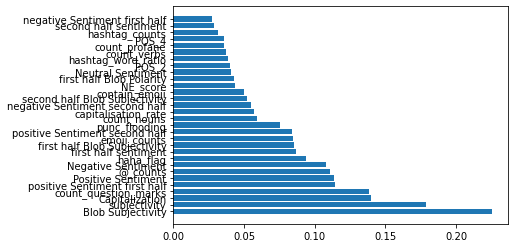

In [ ]:
f_importances(abs(svm.coef_[0]), features_names, top=30)